In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from feature_selection import embedded_method
# plt.style.use('seaborn-colorblind')
# %matplotlib inline


## Load Dataset

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [3]:
data.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['target'], axis=1), 
                                                    data.target, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((455, 30), (114, 30))

## Lasso
Regularization with Lasso.Lasso (L1) has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model

In [5]:
# linear models benefit from feature scaling

scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [6]:
# fit the LR model
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
# sel_ = SelectFromModel(LogisticRegression(C=1, solver='liblinear', penalty='l1'))
sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=1))

In [7]:
# make a list with the selected features
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 30
selected features: 16
features with coefficients shrank to zero: 0


In [8]:
# we can identify the removed features like this:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index([], dtype='object')

In [9]:
# remove the features from the training and testing set

X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))

X_train_selected.shape, X_test_selected.shape

/home/hung/.local/share/virtualenvs/stock_investing-PNNd6zCB/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/hung/.local/share/virtualenvs/stock_investing-PNNd6zCB/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((455, 16), (114, 16))

## Random Forest Importance


Feature ranking:
1. feature no:27 feature name:worst concave points (0.206316)
2. feature no:22 feature name:worst perimeter (0.147163)
3. feature no:7 feature name:mean concave points (0.100672)
4. feature no:20 feature name:worst radius (0.082449)
5. feature no:6 feature name:mean concavity (0.060420)
6. feature no:2 feature name:mean perimeter (0.048284)
7. feature no:23 feature name:worst area (0.046151)
8. feature no:3 feature name:mean area (0.038594)
9. feature no:13 feature name:area error (0.035627)
10. feature no:0 feature name:mean radius (0.030476)
11. feature no:10 feature name:radius error (0.028711)
12. feature no:26 feature name:worst concavity (0.028533)
13. feature no:12 feature name:perimeter error (0.019986)
14. feature no:21 feature name:worst texture (0.018623)
15. feature no:1 feature name:mean texture (0.013840)
16. feature no:25 feature name:worst compactness (0.013195)
17. feature no:29 feature name:worst fractal dimension (0.011840)
18. feature no:24 feature 

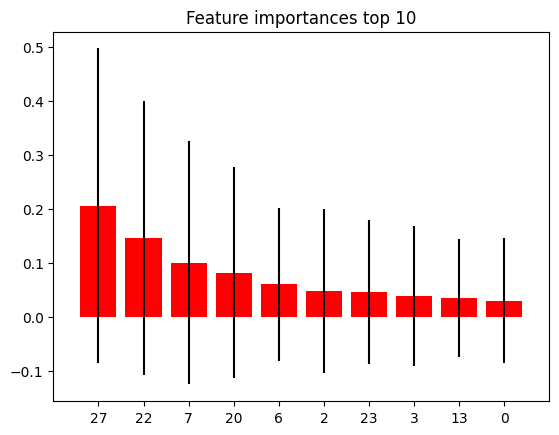

In [10]:
model = embedded_method.rf_importance(X_train=X_train,y_train=y_train,
                             max_depth=10,top_n=10)

In [11]:
# select features whose importance > threshold
from sklearn.feature_selection import SelectFromModel

# only 5 features have importance > 0.05
feature_selection = SelectFromModel(model, threshold=0.05,prefit=True) 
selected_feat = X_train.columns[(feature_selection.get_support())]
selected_feat

Index(['mean concavity', 'mean concave points', 'worst radius',
       'worst perimeter', 'worst concave points'],
      dtype='object')

In [12]:
# only 12 features have importance > 2 times median
feature_selection2 = SelectFromModel(model, threshold='2*median',prefit=True) 
selected_feat2 = X_train.columns[(feature_selection2.get_support())]
selected_feat2

Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'radius error', 'area error', 'worst radius',
       'worst perimeter', 'worst area', 'worst concavity',
       'worst concave points'],
      dtype='object')

## Gradient Boosted Trees Importance

Feature ranking:
1. feature no:27 feature name:worst concave points (0.694636)
2. feature no:23 feature name:worst area (0.131708)
3. feature no:4 feature name:mean smoothness (0.033800)
4. feature no:8 feature name:mean symmetry (0.018183)
5. feature no:22 feature name:worst perimeter (0.016628)
6. feature no:21 feature name:worst texture (0.013900)
7. feature no:2 feature name:mean perimeter (0.013036)
8. feature no:26 feature name:worst concavity (0.010124)
9. feature no:13 feature name:area error (0.008934)
10. feature no:17 feature name:concave points error (0.008310)
11. feature no:0 feature name:mean radius (0.005684)
12. feature no:18 feature name:symmetry error (0.005472)
13. feature no:12 feature name:perimeter error (0.005356)
14. feature no:3 feature name:mean area (0.005069)
15. feature no:1 feature name:mean texture (0.004852)
16. feature no:10 feature name:radius error (0.003850)
17. feature no:16 feature name:concavity error (0.003595)
18. feature no:19 feature name:fra

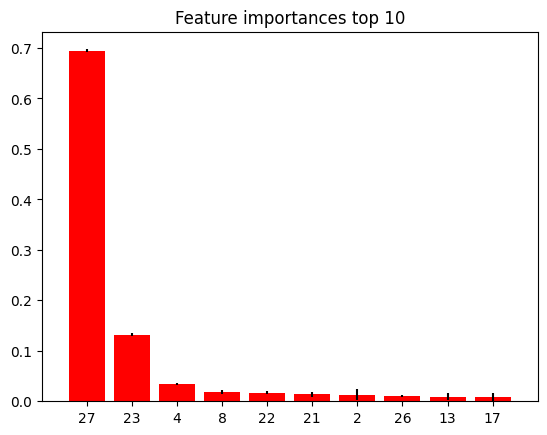

In [13]:
model = embedded_method.gbt_importance(X_train=X_train,y_train=y_train,
                             max_depth=10,top_n=10)

In [14]:
# select features whose importance > threshold

# only 8 features have importance > 0.01
feature_selection = SelectFromModel(model, threshold=0.01,prefit=True) 
selected_feat = X_train.columns[(feature_selection.get_support())]
selected_feat

Index(['mean perimeter', 'mean smoothness', 'mean symmetry', 'worst texture',
       'worst perimeter', 'worst area', 'worst concavity',
       'worst concave points'],
      dtype='object')